! pip install youtube-comment-downloader 

In [1]:
from youtube_comment_downloader import YoutubeCommentDownloader
import pandas as pd
import time 


In [ ]:
#video_id ber korte hobe 
#

In [6]:
video_ids = [
    "K0B2qlb8eVI",
    "5NLf7O6BF6s"
]

MAX_COMMENTS_PER_VIDEO = 200
SLEEP_SECONDS = 0.000001

downloader = YoutubeCommentDownloader()
all_data = []

for vid in video_ids:
    print(f"Downloading comments for video: {vid}")
    url = f"https://www.youtube.com/watch?v={vid}"

    try:
        comments = downloader.get_comments_from_url(url)
        for idx, comment in enumerate(comments, start=1):
            # Some videos/comments do not include all fields (e.g., likes).
            likes = comment.get("likes", comment.get("votes", 0))
            all_data.append({
                "video_id": vid,
                "comment": comment.get("text", ""),
                "author": comment.get("author", ""),
                "likes": likes,
                "published_at": comment.get("published_at", comment.get("time", ""))
            })

            if idx % 50 == 0:
                print(f"  Collected {idx} comments from {vid}...")

            if idx >= MAX_COMMENTS_PER_VIDEO:
                print(f"  Reached limit ({MAX_COMMENTS_PER_VIDEO}) for {vid}")
                break

            time.sleep(SLEEP_SECONDS)
    except Exception as e:
        print(f"Error downloading comments for video {vid}: {e}")

df = pd.DataFrame(all_data)
df.to_csv("youtube_comments.csv", index=False, encoding='utf-8-sig')
print(f"Comments downloaded and saved to youtube_comments.csv. Total rows: {len(df)}")


  Collected 50 comments from K0B2qlb8eVI...
  Collected 100 comments from K0B2qlb8eVI...
  Collected 150 comments from K0B2qlb8eVI...
  Collected 200 comments from K0B2qlb8eVI...
  Reached limit (200) for K0B2qlb8eVI
  Collected 50 comments from 5NLf7O6BF6s...
  Collected 100 comments from 5NLf7O6BF6s...
  Collected 150 comments from 5NLf7O6BF6s...
  Collected 200 comments from 5NLf7O6BF6s...
  Reached limit (200) for 5NLf7O6BF6s
Comments downloaded and saved to youtube_comments.csv. Total rows: 400


nlp - preprocessing 

In [7]:
! pip install  nltk spacy emoji langdetect 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 5.4 MB/s  0:00:0036m-:--:--
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 2.9 MB/s  0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993332 sha256=80496222a29ebea642e1bb0f0f40d924345a62e2bfb561f4db7ced38669789c6
  Stored in directory: /Users/imac/Library/Caches/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [emoji]


In [9]:
! pip install spacy

In [12]:
import spacy.cli
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 113.9 kB/s  0:01:160:00:0300:05
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Test if spacy model is already available
import spacy
nlp = spacy.load("en_core_web_sm")
print("✓ Spacy model 'en_core_web_sm' is already installed and working!")

✓ Spacy model 'en_core_web_sm' is already installed and working!


In [3]:
import pandas as pd 
import re 
import nltk 
import spacy 
import emoji 
from langdetect import detect 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to /Users/imac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/imac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df=pd.read_csv("youtube_comments.csv")
df.head()

,video_id,comment,author,likes,published_at
0,K0B2qlb8eVI,India is a very powerful country,@BoazMwadime-b1k,0,6 ঘণ্টা আগে
1,K0B2qlb8eVI,Common denominator with all Islamist is they a...,@clevelandwilliams5922,0,12 ঘণ্টা আগে
2,K0B2qlb8eVI,Let’s talk about all the children that disappe...,@PeterWright-y3b,0,15 ঘণ্টা আগে
3,K0B2qlb8eVI,So they sent the master of disaster,@andrewpetersen6116,0,15 ঘণ্টা আগে
4,K0B2qlb8eVI,Muslims wanted Pakistan and killed hindus for ...,@AshishVerma-dz9ug,0,1 দিন আগে


In [6]:
comment_column = None

# 1) Preferred exact/keyword matches
priority_names = {"comment", "comments", "text", "review", "message", "body"}
for col in df.columns:
    col_l = str(col).strip().lower()
    if col_l in priority_names or any(k in col_l for k in ["comment", "text", "review", "message"]):
        comment_column = col
        break

# 2) Fallback: first object/string-like column with non-empty values
if comment_column is None:
    for col in df.columns:
        series = df[col]
        if series.dtype == "object" and series.dropna().astype(str).str.strip().ne("").any():
            comment_column = col
            break

print(f"Identified comment column: {comment_column}")
if comment_column is None:
    raise ValueError(f"Could not identify a comment/text column. Available columns: {list(df.columns)}")


Identified comment column: comment


In [7]:
stop_words = set(stopwords.words('english'))
def clean_text_nlp(text):
    if pd.isna(text):
        return "","unknown"
    text=str(text)
    # try urls 
    try:
        lang=detect(text)
    except:
        lang="unknown"
    # remove emojis
    text=emoji.replace_emoji(text,replace="")
    # remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text=text.lower()
    #keep english and bangla letters 
    text = re.sub(r"[^a-zA-Z\u0980-\u09FF\s]", "", text)
    # tokenize
    tokens = word_tokenize(text)
    # remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    # lemmatize
    doc = nlp(" ".join(tokens))
    lemmas=[token.lemma_ for token in doc]
    cleaned_text=" ".join(lemmas)
    return cleaned_text,lang





apply preprocessing 

In [8]:
cleaned_texts=[]
languages=[]
for text in df[comment_column]:
    cleaned,lang=clean_text_nlp(text)
    cleaned_texts.append(cleaned)
    languages.append(lang)
df["cleaned_comment"]=cleaned_texts
df["language"]=languages
df.head()

,video_id,comment,author,likes,published_at,cleaned_comment,language
0,K0B2qlb8eVI,India is a very powerful country,@BoazMwadime-b1k,0,6 ঘণ্টা আগে,india powerful country,en
1,K0B2qlb8eVI,Common denominator with all Islamist is they a...,@clevelandwilliams5922,0,12 ঘণ্টা আগে,common denominator islamist attach cause separ...,en
2,K0B2qlb8eVI,Let’s talk about all the children that disappe...,@PeterWright-y3b,0,15 ঘণ্টা আগে,let talk child disappear mountbatten indian le...,en
3,K0B2qlb8eVI,So they sent the master of disaster,@andrewpetersen6116,0,15 ঘণ্টা আগে,send master disaster,en
4,K0B2qlb8eVI,Muslims wanted Pakistan and killed hindus for ...,@AshishVerma-dz9ug,0,1 দিন আগে,muslims want pakistan kill hindus million musl...,en


remove empty and duplicants 

In [9]:
df=df[df['cleaned_comment'].str.strip()!=""]
df.head()

,video_id,comment,author,likes,published_at,cleaned_comment,language
0,K0B2qlb8eVI,India is a very powerful country,@BoazMwadime-b1k,0,6 ঘণ্টা আগে,india powerful country,en
1,K0B2qlb8eVI,Common denominator with all Islamist is they a...,@clevelandwilliams5922,0,12 ঘণ্টা আগে,common denominator islamist attach cause separ...,en
2,K0B2qlb8eVI,Let’s talk about all the children that disappe...,@PeterWright-y3b,0,15 ঘণ্টা আগে,let talk child disappear mountbatten indian le...,en
3,K0B2qlb8eVI,So they sent the master of disaster,@andrewpetersen6116,0,15 ঘণ্টা আগে,send master disaster,en
4,K0B2qlb8eVI,Muslims wanted Pakistan and killed hindus for ...,@AshishVerma-dz9ug,0,1 দিন আগে,muslims want pakistan kill hindus million musl...,en


In [10]:
df=df.drop_duplicates(subset=["cleaned_comment"])
df.head()

,video_id,comment,author,likes,published_at,cleaned_comment,language
0,K0B2qlb8eVI,India is a very powerful country,@BoazMwadime-b1k,0,6 ঘণ্টা আগে,india powerful country,en
1,K0B2qlb8eVI,Common denominator with all Islamist is they a...,@clevelandwilliams5922,0,12 ঘণ্টা আগে,common denominator islamist attach cause separ...,en
2,K0B2qlb8eVI,Let’s talk about all the children that disappe...,@PeterWright-y3b,0,15 ঘণ্টা আগে,let talk child disappear mountbatten indian le...,en
3,K0B2qlb8eVI,So they sent the master of disaster,@andrewpetersen6116,0,15 ঘণ্টা আগে,send master disaster,en
4,K0B2qlb8eVI,Muslims wanted Pakistan and killed hindus for ...,@AshishVerma-dz9ug,0,1 দিন আগে,muslims want pakistan kill hindus million musl...,en


In [11]:
df.to_csv("youtube_comments_cleaned.csv", index=False, encoding='utf-8-sig')
print(f"Cleaned comments saved to youtube_comments_cleaned.csv. Total rows: {len(df)}")

Cleaned comments saved to youtube_comments_cleaned.csv. Total rows: 391


relevant comment filter

In [12]:
keywords=[
    "india","pakistan","kasmir","modi","imran","army","border","war","peace","terrorism"
]
df["is_relevant"]=df["cleaned_comment"].apply(lambda x: any(k in x for k in keywords))
df_filtered=df[df["is_relevant"]==True]
print(f"Relevant data shape: {df_filtered.shape}")
df_filtered.head()

Relevant data shape: (213, 8)


,video_id,comment,author,likes,published_at,cleaned_comment,language,is_relevant
0,K0B2qlb8eVI,India is a very powerful country,@BoazMwadime-b1k,0,6 ঘণ্টা আগে,india powerful country,en,True
1,K0B2qlb8eVI,Common denominator with all Islamist is they a...,@clevelandwilliams5922,0,12 ঘণ্টা আগে,common denominator islamist attach cause separ...,en,True
2,K0B2qlb8eVI,Let’s talk about all the children that disappe...,@PeterWright-y3b,0,15 ঘণ্টা আগে,let talk child disappear mountbatten indian le...,en,True
4,K0B2qlb8eVI,Muslims wanted Pakistan and killed hindus for ...,@AshishVerma-dz9ug,0,1 দিন আগে,muslims want pakistan kill hindus million musl...,en,True
5,K0B2qlb8eVI,It was a master plan by the west a divided Ind...,@greggarcia9842,0,1 দিন আগে,master plan west divide india good western power,en,True


In [13]:
df_sample=df_filtered.sample(n=500, random_state=42,replace=True)
df_sample.to_csv("manual_label_data.csv", index=False, encoding='utf-8-sig')
print("Exported 500 relevant comments to manual_label_data.csv for manual labeling.")

Exported 500 relevant comments to manual_label_data.csv for manual labeling.


In [37]:
! pip install transformers torch

In [14]:
from transformers import pipeline

classifier = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

df = pd.read_csv("youtube_comments.csv")

# Ensure cleaned_comment exists even if the raw CSV has only comment/text columns.
if "cleaned_comment" not in df.columns:
    candidate_cols = [c for c in df.columns if "comment" in str(c).lower() or "text" in str(c).lower()]
    if not candidate_cols:
        raise KeyError(f"No comment/text column found. Available columns: {list(df.columns)}")
    df["cleaned_comment"] = df[candidate_cols[0]]

# Normalize and keep non-empty text only.
df["cleaned_comment"] = df["cleaned_comment"].fillna("").astype(str)
df = df[df["cleaned_comment"].str.strip() != ""].copy()
df.head()


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


,video_id,comment,author,likes,published_at,cleaned_comment
0,K0B2qlb8eVI,India is a very powerful country,@BoazMwadime-b1k,0,6 ঘণ্টা আগে,India is a very powerful country
1,K0B2qlb8eVI,Common denominator with all Islamist is they a...,@clevelandwilliams5922,0,12 ঘণ্টা আগে,Common denominator with all Islamist is they a...
2,K0B2qlb8eVI,Let’s talk about all the children that disappe...,@PeterWright-y3b,0,15 ঘণ্টা আগে,Let’s talk about all the children that disappe...
3,K0B2qlb8eVI,So they sent the master of disaster,@andrewpetersen6116,0,15 ঘণ্টা আগে,So they sent the master of disaster
4,K0B2qlb8eVI,Muslims wanted Pakistan and killed hindus for ...,@AshishVerma-dz9ug,0,1 দিন আগে,Muslims wanted Pakistan and killed hindus for ...


In [16]:
def auto_label(text):
    result = classifier(str(text))[0]
    raw_label = str(result.get("label", "")).strip().lower()

    label_map = {
        "label_0": "negative",
        "label_1": "neutral",
        "label_2": "positive",
        "negative": "negative",
        "neutral": "neutral",
        "positive": "positive"
    }

    if raw_label in label_map:
        return label_map[raw_label]

    if "neg" in raw_label:
        return "negative"
    if "neu" in raw_label:
        return "neutral"
    if "pos" in raw_label:
        return "positive"

    return "neutral"


df["label"] = df["cleaned_comment"].apply(auto_label)
print(df["label"].value_counts(dropna=False))
df.head(50)


label
negative    223
neutral     142
positive     35
Name: count, dtype: int64


,video_id,comment,author,likes,published_at,cleaned_comment,label
0,K0B2qlb8eVI,India is a very powerful country,@BoazMwadime-b1k,0,6 ঘণ্টা আগে,India is a very powerful country,positive
1,K0B2qlb8eVI,Common denominator with all Islamist is they a...,@clevelandwilliams5922,0,12 ঘণ্টা আগে,Common denominator with all Islamist is they a...,negative
2,K0B2qlb8eVI,Let’s talk about all the children that disappe...,@PeterWright-y3b,0,15 ঘণ্টা আগে,Let’s talk about all the children that disappe...,negative
3,K0B2qlb8eVI,So they sent the master of disaster,@andrewpetersen6116,0,15 ঘণ্টা আগে,So they sent the master of disaster,negative
4,K0B2qlb8eVI,Muslims wanted Pakistan and killed hindus for ...,@AshishVerma-dz9ug,0,1 দিন আগে,Muslims wanted Pakistan and killed hindus for ...,negative
5,K0B2qlb8eVI,It was a master plan by the west a divided Ind...,@greggarcia9842,0,1 দিন আগে,It was a master plan by the west a divided Ind...,negative
6,K0B2qlb8eVI,This is definitely a a BBC version of the part...,@edivimaro1975,0,1 দিন আগে,This is definitely a a BBC version of the part...,negative
7,K0B2qlb8eVI,The British say that they civilised India.\n\n...,@edivimaro1975,0,1 দিন আগে,The British say that they civilised India.\n\n...,neutral
8,K0B2qlb8eVI,Muslim India was born as Muslim State \nHindu ...,@vettrimaaran3257,0,2 দিন আগে,Muslim India was born as Muslim State \nHindu ...,neutral
9,K0B2qlb8eVI,No mention of Cyrill Radcliffe. The man who cr...,@rizfpv,0,4 দিন আগে,No mention of Cyrill Radcliffe. The man who cr...,negative


In [44]:
df.tail(50)

,video_id,comment,author,likes,published_at,cleaned_comment,label
350,5NLf7O6BF6s,Good to know.....,@LadyLyriasProductionsLTD,0,1 বছর পূর্বে,Good to know.....,positive
351,5NLf7O6BF6s,We don’t forget what they did to the train,@Nullmasker,0,1 বছর পূর্বে,We don’t forget what they did to the train,negative
352,5NLf7O6BF6s,"Very interesting and succinct, thanks",@parrhasius,0,1 বছর পূর্বে,"Very interesting and succinct, thanks",positive
353,5NLf7O6BF6s,Lil bro it was a trade,@Patriotic_indianedits,0,1 বছর পূর্বে,Lil bro it was a trade,neutral
354,5NLf7O6BF6s,Pant removing ceremony was cool also in 1971.....,@athulskumar9361,0,9 মাস আগে,Pant removing ceremony was cool also in 1971.....,positive
355,5NLf7O6BF6s,The only achievement of Punjabi moslems in the...,@HeavenRacer422,0,6 মাস আগে,The only achievement of Punjabi moslems in the...,positive
356,5NLf7O6BF6s,Tell us true 😂,@sunilk490,1,1 বছর পূর্বে,Tell us true 😂,neutral
357,5NLf7O6BF6s,You should read some reliable books get out of...,@User28661,0,1 বছর পূর্বে,You should read some reliable books get out of...,neutral
358,5NLf7O6BF6s,Nope,@Patriotic_indianedits,0,1 বছর পূর্বে,Nope,neutral
359,5NLf7O6BF6s,Pakistan attacked every single time,@Patriotic_indianedits,0,1 বছর পূর্বে (সম্পাদনা করা হয়েছে),Pakistan attacked every single time,negative


In [ ]:
df.to_csv("auto_labeled_comments.csv", index=False, encoding='utf-8-sig')
print("Auot label done ")

Auot label done 


In [15]:
df_sample=df.sample(200, random_state=42)
df_sample.to_csv("manual_correction_200.csv", index=False, encoding='utf-8-sig')
print("Exported 200 random comments to manual_correction_200.csv for manual review and correction.")

Exported 200 random comments to manual_correction_200.csv for manual review and correction.


In [37]:
df_corrected = pd.read_csv("manual_correction_200.csv")
df_corrected["label"].value_counts()

label
negative    116
neutral      69
positive     15
Name: count, dtype: int64

fine tune bert 

In [38]:
label_map={
    "negative": 0,
    "neutral": 1,
    "positive": 2
}
df_corrected["label"] = df_corrected["label"].astype(str).str.strip().str.lower()
df_corrected = df_corrected[df_corrected["label"].isin(label_map.keys())].copy()
df_corrected["label_id"] = df_corrected["label"].map(label_map).astype(int)

In [39]:
from sklearn.model_selection import train_test_split

# Safety cleanup in case old label_id values (e.g., 4) still exist in memory/file
df_corrected["label_id"] = pd.to_numeric(df_corrected["label_id"], errors="coerce")
df_corrected["label_id"] = df_corrected["label_id"].replace({4: 1})
df_corrected = df_corrected[df_corrected["label_id"].isin([0, 1, 2])].copy()
df_corrected["label_id"] = df_corrected["label_id"].astype(int)

train_texts,val_texts,train_labels,val_labels=train_test_split(
    df_corrected["cleaned_comment"],
    df_corrected["label_id"],
    test_size=0.2,
    random_state=42,
    stratify=df_corrected["label_id"]
)

train_labels = pd.to_numeric(train_labels, errors="coerce").replace({4: 1}).astype(int)
val_labels = pd.to_numeric(val_labels, errors="coerce").replace({4: 1}).astype(int)

In [40]:
from transformers import AutoTokenizer, DataCollatorWithPadding
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
train_encodings = tokenizer(train_texts.tolist(), truncation=True, max_length=48)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, max_length=48)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [41]:
import torch

class CommentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings

        label_map = {
            "negative": 0,
            "neutral": 1,
            "positive": 2,
            "label_0": 0,
            "label_1": 1,
            "label_2": 2
        }

        self.labels = []
        for x in labels:
            if isinstance(x, str):
                key = x.strip().lower()
                if key in label_map:
                    self.labels.append(label_map[key])
                elif key.isdigit():
                    self.labels.append(int(key))
                else:
                    raise ValueError(f"Unknown label value: {x}")
            else:
                if x is None or x != x:  # None/NaN
                    raise ValueError(f"Invalid label value: {x}")
                self.labels.append(int(x))

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CommentDataset(train_encodings, train_labels.tolist())
val_dataset = CommentDataset(val_encodings, val_labels.tolist())

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_labels_clean = pd.to_numeric(train_labels, errors="coerce")
train_labels_clean = train_labels_clean.replace({4: 1})
invalid_mask = ~train_labels_clean.isin([0, 1, 2])
if invalid_mask.any():
    bad_values = sorted(train_labels_clean[invalid_mask].dropna().unique().tolist())
    print("Warning: invalid train label(s) found, replacing with neutral=1:", bad_values)
    train_labels_clean.loc[invalid_mask] = 1
train_labels_clean = train_labels_clean.astype(int)

present_classes = np.array([0, 1, 2])
base_weights = compute_class_weight(
    class_weight="balanced",
    classes=present_classes,
    y=train_labels_clean.to_numpy()
)
base_weights = torch.tensor(base_weights, dtype=torch.float)
class_weights = base_weights.clone()
class_weights = class_weights / class_weights.mean()

# Softer sampling (sqrt of class weight) to reduce single-class collapse
sampling_alpha = 0.5
train_sample_weights = torch.tensor(
    [float(class_weights[int(lbl)].item() ** sampling_alpha) for lbl in train_labels_clean.tolist()],
    dtype=torch.double
)
print("Train label counts:\n", train_labels_clean.value_counts().sort_index())
print("Base class weights:", base_weights)
print("Final class weights:", class_weights)


Train label counts:
 label_id
0    93
1    55
2    12
Name: count, dtype: int64
Base class weights: tensor([0.5735, 0.9697, 4.4444])
Final class weights: tensor([0.2873, 0.4859, 2.2268])


In [42]:
from transformers import AutoModelForSequenceClassification
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

for param in model.roberta.embeddings.parameters():
    param.requires_grad = False
for layer in model.roberta.encoder.layer[:8]:
    for param in layer.parameters():
        param.requires_grad = False


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    per_device_eval_batch_size=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    optim="adamw_torch",
    gradient_checkpointing=False,
    dataloader_pin_memory=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none"
)

In [ ]:
import gc
from sklearn.metrics import f1_score

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, train_sample_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.train_sample_weights = train_sample_weights

    def get_train_dataloader(self):
        from torch.utils.data import DataLoader, WeightedRandomSampler

        sampler = WeightedRandomSampler(
            weights=self.train_sample_weights,
            num_samples=len(self.train_sample_weights),
            replacement=True
        )
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=sampler,
            collate_fn=self.data_collator,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    accuracy = float((preds == labels).mean())
    macro_f1 = f1_score(labels, preds, average="macro", zero_division=0)
    weighted_f1 = f1_score(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": accuracy, "macro_f1": macro_f1, "weighted_f1": weighted_f1}

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    train_sample_weights=train_sample_weights
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.061000,0.959752,0.475000,0.323810,0.468571
2,1.020500,0.859255,0.575000,0.247312,0.426613
3,0.990600,0.813206,0.575000,0.243386,0.419841


In [35]:
trainer.evaluate()


{'eval_loss': 0.7160321474075317,
 'eval_accuracy': 0.075,
 'eval_macro_f1': 0.046511627906976744,
 'eval_weighted_f1': 0.010465116279069767,
 'eval_runtime': 6.9214,
 'eval_samples_per_second': 5.779,
 'eval_steps_per_second': 5.779,
 'epoch': 2.0}

Predicted label counts:
 2    40
Name: count, dtype: int64
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        23
     neutral       0.07      1.00      0.14         3
    positive       0.00      0.00      0.00        14

    accuracy                           0.07        40
   macro avg       0.02      0.33      0.05        40
weighted avg       0.01      0.07      0.01        40

Confusion Matrix:
[[ 0 23  0]
 [ 0  3  0]
 [ 0 14  0]]


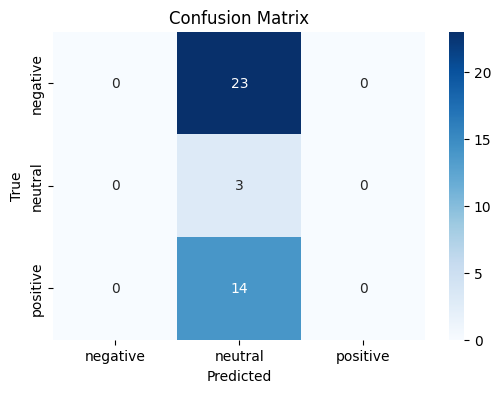

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
predictions=trainer.predict(val_dataset)
preds=predictions.predictions.argmax(axis=-1)
label_order = [0, 1, 2]
print("True label counts:\n", pd.Series(val_labels).value_counts().sort_index().reindex(label_order, fill_value=0))
print("Predicted label counts:\n", pd.Series(preds).value_counts().sort_index().reindex(label_order, fill_value=0))
print(classification_report(val_labels, preds, labels=label_order, target_names=["negative", "neutral", "positive"], zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(val_labels, preds, labels=label_order))  
from matplotlib import pyplot as plt
import seaborn as sns
cm = confusion_matrix(val_labels, preds, labels=label_order)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()